In [1]:
%load_ext autoreload
%autoreload 2

# Environment prep for Colab
 - download git repo 
 - install required pip packages

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!git clone https://github.com/kkahloots/Rethinking_Data_Effeient_GANs.git

Cloning into 'Rethinking_Data_Effeient_GANs'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 1038 (delta 0), reused 2 (delta 0), pack-reused 1030
Receiving objects: 100% (1038/1038), 232.90 MiB | 40.91 MiB/s, done.
Resolving deltas: 100% (88/88), done.
Checking out files: 100% (872/872), done.


In [4]:
!ls

drive  Rethinking_Data_Effeient_GANs  sample_data


In [5]:
!wget https://hanlab.mit.edu/projects/data-efficient-gans/datasets/AnimalFace-dog.zip 

--2020-12-10 20:18:06--  https://hanlab.mit.edu/projects/data-efficient-gans/datasets/AnimalFace-dog.zip
Resolving hanlab.mit.edu (hanlab.mit.edu)... 18.25.8.36
Connecting to hanlab.mit.edu (hanlab.mit.edu)|18.25.8.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8990601 (8.6M) [application/zip]
Saving to: ‘AnimalFace-dog.zip’

AnimalFace-dog.zip  100%[===================>]   8.57M  48.8MB/s    in 0.2s    

2020-12-10 20:18:06 (48.8 MB/s) - ‘AnimalFace-dog.zip’ saved [8990601/8990601]



In [6]:
!mkdir  Rethinking_Data_Effeient_GANs/data/.AnimalFace-dog
!mkdir  "Rethinking_Data_Effeient_GANs/data/.AnimalFace-dog/1"

In [7]:
!unzip ./AnimalFace-dog.zip -d "Rethinking_Data_Effeient_GANs/data/.AnimalFace-dog/1"

Archive:  ./AnimalFace-dog.zip
  inflating: Rethinking_Data_Effeient_GANs/data/.AnimalFace-dog/1/380.jpg  
  inflating: Rethinking_Data_Effeient_GANs/data/.AnimalFace-dog/1/381.jpg  
  inflating: Rethinking_Data_Effeient_GANs/data/.AnimalFace-dog/1/382.jpg  
  inflating: Rethinking_Data_Effeient_GANs/data/.AnimalFace-dog/1/383.jpg  
  inflating: Rethinking_Data_Effeient_GANs/data/.AnimalFace-dog/1/384.jpg  
  inflating: Rethinking_Data_Effeient_GANs/data/.AnimalFace-dog/1/385.jpg  
  inflating: Rethinking_Data_Effeient_GANs/data/.AnimalFace-dog/1/386.jpg  
  inflating: Rethinking_Data_Effeient_GANs/data/.AnimalFace-dog/1/387.jpg  
  inflating: Rethinking_Data_Effeient_GANs/data/.AnimalFace-dog/1/388.jpg  
  inflating: Rethinking_Data_Effeient_GANs/data/.AnimalFace-dog/1/0.jpg  
  inflating: Rethinking_Data_Effeient_GANs/data/.AnimalFace-dog/1/1.jpg  
  inflating: Rethinking_Data_Effeient_GANs/data/.AnimalFace-dog/1/2.jpg  
  inflating: Rethinking_Data_Effeient_GANs/data/.AnimalFace-dog

In [8]:
!rm -rf ./AnimalFace-dog.zip

# Connect Drive to save and restore results

# Settings

In [9]:
%env TF_KERAS = 1
import os
sep_local = os.path.sep

import sys
print(sep_local)

env: TF_KERAS=1
/


In [10]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [11]:
os.getcwd()

'/content'

In [12]:
os.chdir('/content/Rethinking_Data_Effeient_GANs')
print(os.getcwd())

/content/Rethinking_Data_Effeient_GANs


# only on colab

# Dataset loading

In [13]:
!pip install -q colorlog tqdm Augmentor livelossplot


In [14]:
from generators.from_images.file_image_generator import get_generators, create_image_lists

In [16]:
dataset_name='AnimalFace-dog'
inputs_shape= image_shape=(128, 128, 3)
batch_size = 36
latents_dim = 256
intermediate_dim = 50
img_dir = 'data/.AnimalFace-dog'

In [17]:
restore_path = '/content/drive/MyDrive/Rethinking_Data_Effeient_GANs/saved_models/AUG_PLUS_WGAN_GP'

In [19]:
import pickle

In [20]:
try:
    imgs_list = pickle.load(open(f'{restore_path}/{dataset_name}_images_list.pkl', 'rb'))
except:
      imgs_list = create_image_lists(
      image_dir=img_dir, 
      validation_pct=10, 
      valid_imgae_formats='jpg'
      )
      pickle.dump(imgs_list, open(f'{restore_path}/{dataset_name}_images_list.pkl', 'wb'))


  DEBUG    | Looking for images in '1'
  INFO     | 389 file found


In [21]:
train_generator, val_generator = get_generators(
        images_list=imgs_list, 
        image_size=image_shape, 
        image_dir=img_dir,
        batch_size=batch_size,
        episode_len=None,
        episode_shift=None,
        class_mode=None
        )

  INFO     | Found 340 training files
  INFO     | Found 49 validation files


In [22]:
def gen2ds(gen):
  while True:
    for batch in gen:
      yield {'images': batch}


In [23]:
train_ds = tf.data.Dataset.from_generator(
    lambda: gen2ds(train_generator), 
    output_types={'images': tf.float32}, 
                  )


test_ds = tf.data.Dataset.from_generator(
    lambda: gen2ds(val_generator),     
    output_types={'images': tf.float32}
                  )

In [24]:
for batch in train_ds:
    break

In [25]:
from utils.utils import img_merge

/content/Rethinking_Data_Effeient_GANs/utils/utils.py:33: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [26]:
image_grid = img_merge(batch['images'], n_rows=6).squeeze()

In [27]:
from PIL import Image
import numpy as np

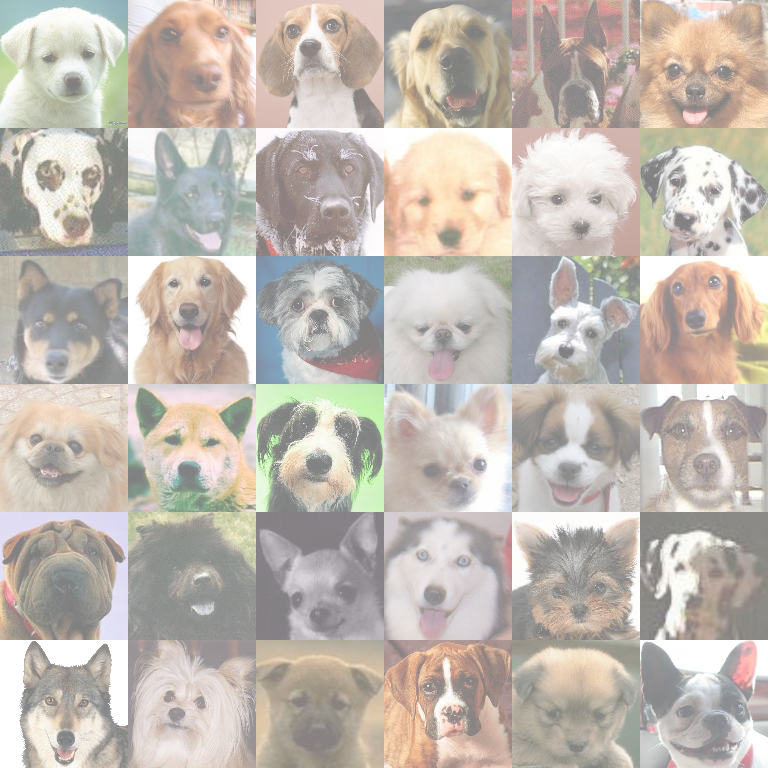

In [28]:
Image.fromarray(image_grid.astype(np.uint8))

In [29]:
from augmentation.DiffAugmentPlus import DiffAugmentPlus

level 1
<function rand_shear at 0x7fca6e178730>


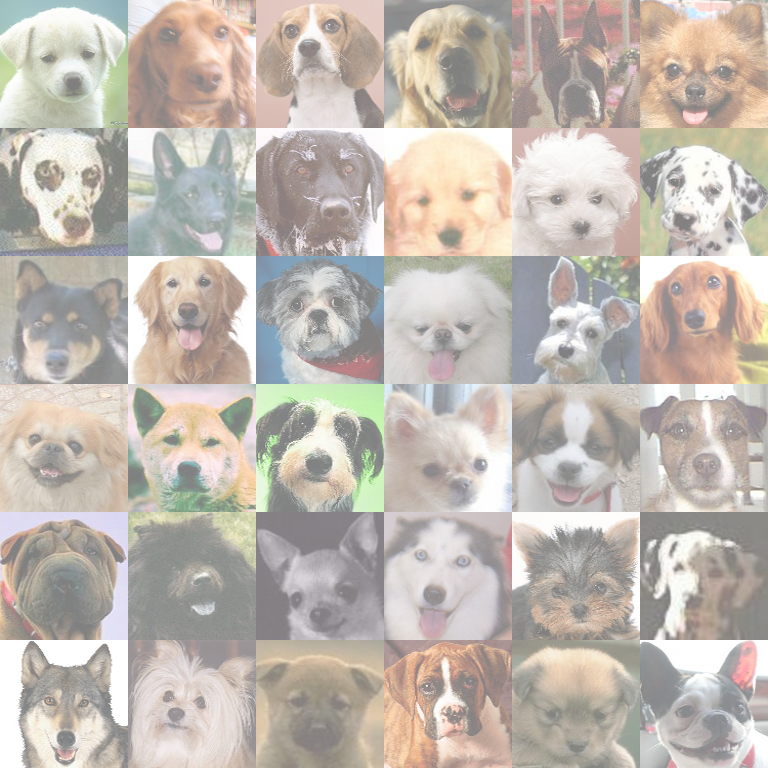

<function rand_contrast at 0x7fca6e178378>


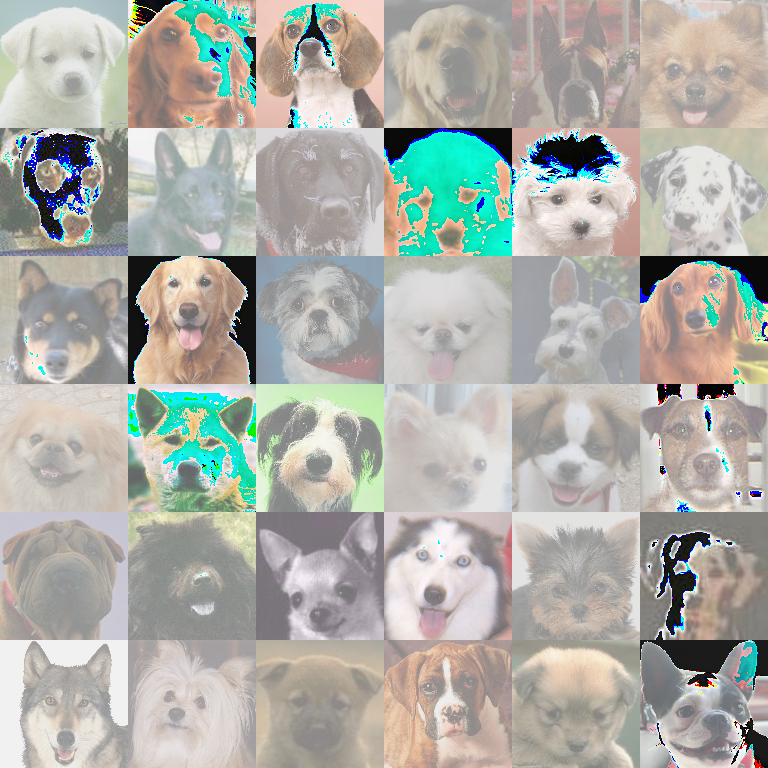

<function clone at 0x7fca6e1787b8>


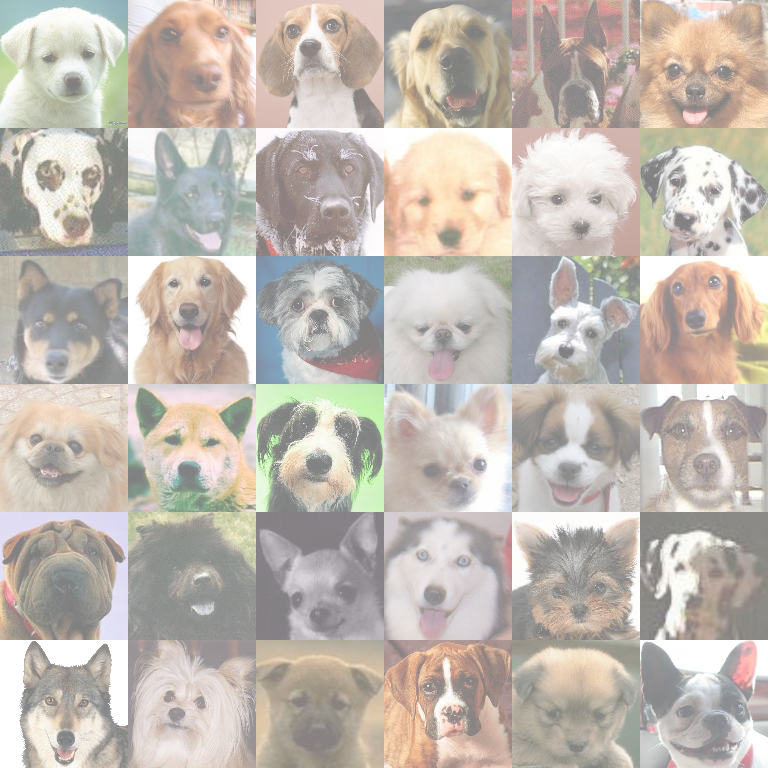

<function rand_skew at 0x7fca6e178598>


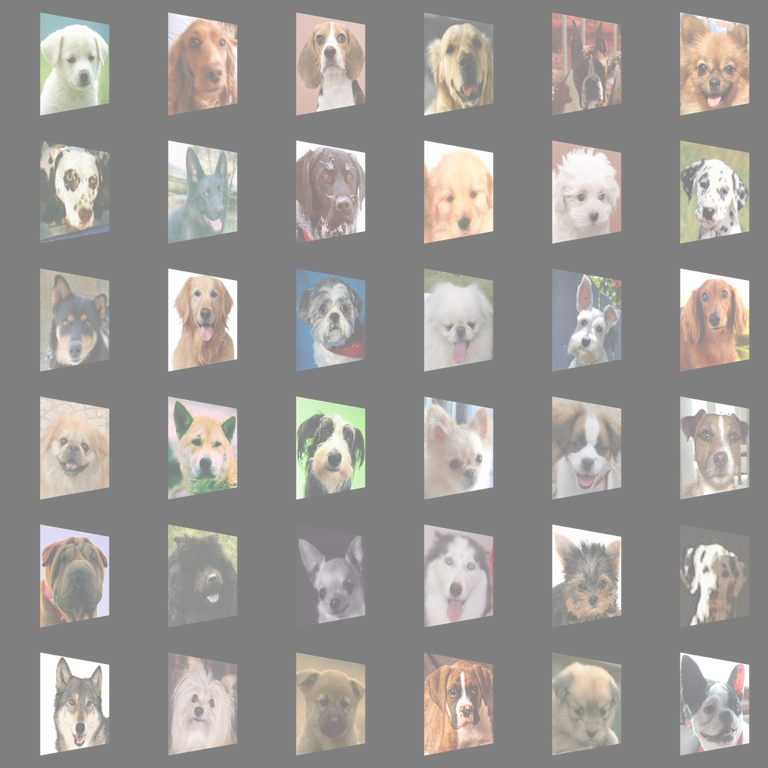

<function rand_rotate at 0x7fca6e178950>


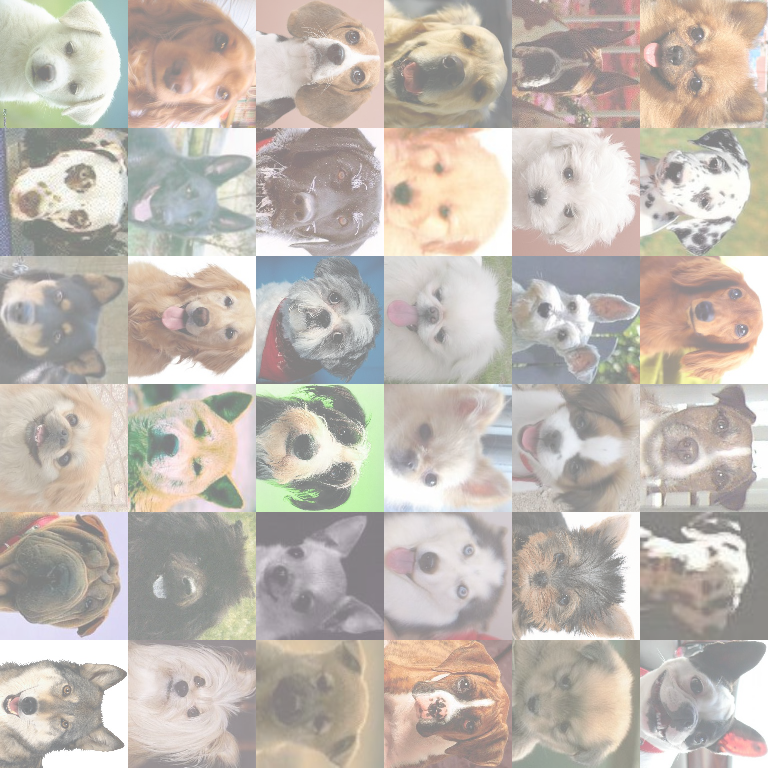

level 2
<function rand_rotate at 0x7fca6e178950>
<function rand_flip at 0x7fca6e178840>


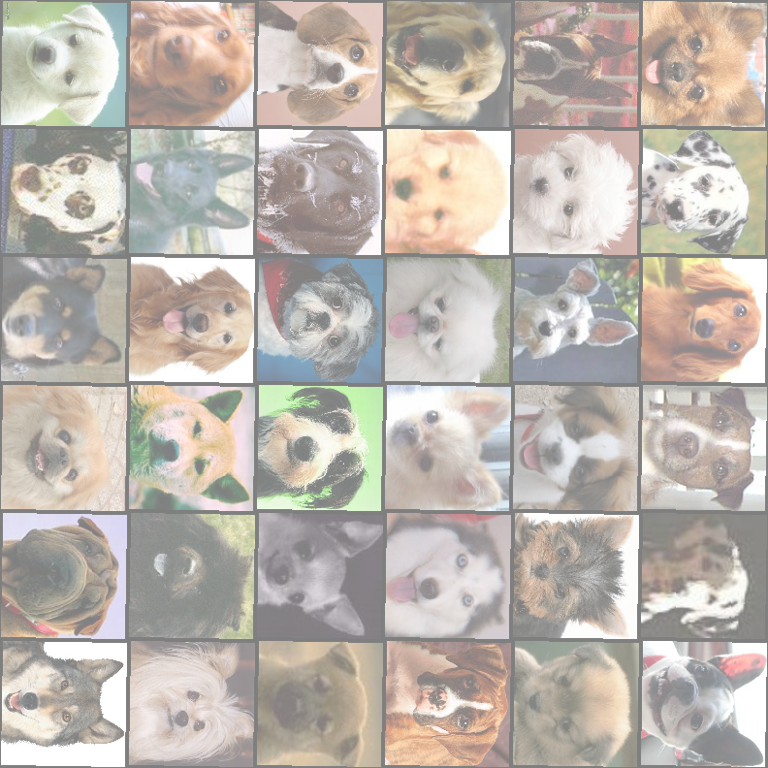

<function rand_distort at 0x7fca6e1786a8>
<function rand_saturation at 0x7fca6e1782f0>


In [ ]:
print('level 1')
for _ in range(5):
    aug_batch = DiffAugmentPlus(batch['images'], level=1)
    image_grid = img_merge(aug_batch, n_rows=6).squeeze()
    display(Image.fromarray(image_grid.astype(np.uint8)))

print('level 2')
for _ in range(5):
    aug_batch = DiffAugmentPlus(batch['images'], level=2)
    image_grid = img_merge(aug_batch, n_rows=6).squeeze()
    display(Image.fromarray(image_grid.astype(np.uint8)))

print('level 3')    
for _ in range(5):
    aug_batch = DiffAugmentPlus(batch['images'], level=3)
    image_grid = img_merge(aug_batch, n_rows=6).squeeze()
    display(Image.fromarray(image_grid.astype(np.uint8)))

print('level 4')     
for _ in range(5):
    aug_batch = DiffAugmentPlus(batch['images'], level=4)
    image_grid = img_merge(aug_batch, n_rows=6).squeeze()
    display(Image.fromarray(image_grid.astype(np.uint8)))    

In [ ]:
import numpy as np
_instance_scale=1.0
for data in test_ds:
    print(np.max(data['images']))
    break
    #print(data.keys())

In [ ]:
[*data['images'][0].shape]

In [ ]:
data.keys()

# Callbacks definition

# Model definition

In [ ]:
from building.AugPlus_WGAN_GP import AugmentPlus_WGAN_GP as AUG_PLUS_GAN

In [ ]:
done = False

In [ ]:

gan_model = AUG_PLUS_GAN(
            model_name=dataset_name+'_AUG_PLUS_GAN', 
            save_path=restore_path, 
            image_size=inputs_shape, 
            z_dim=latents_dim, 
            n_critic=5, 
            batch_size=batch_size,
            g_penalty=10
            )
done = gan_model.train(dataset=train_ds, val_dataset=test_ds, epochs=int(6e4), n_itr=300)


In [ ]:
xxx

In [ ]:
#to restore trained model, set filepath=_restore

In [ ]:
ae = AE( 
    name=model_name,
    latents_dim=latents_dim,
    batch_size=batch_size,
    variables_params=variables_params, 
    filepath=_restore
    )

In [ ]:
ae.compile(metrics=None)

In [ ]:
ae.output_shape

# Callbacks

In [ ]:
from training.callbacks.sample_generation import SampleGeneration
from training.callbacks.save_model import ModelSaver

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=1e-15, 
    patience=10, 
    verbose=1, 
    restore_best_weights=False
)

In [ ]:
ms = ModelSaver(filepath=_restore)

In [ ]:
csv_dir = os.path.join(experiments_dir, 'csv_dir')
create_if_not_exist(csv_dir)
csv_dir = os.path.join(csv_dir, ae.name+'.csv')
csv_log = tf.keras.callbacks.CSVLogger(csv_dir, append=True)
csv_dir

In [ ]:
image_gen_dir = os.path.join(experiments_dir, 'image_gen_dir')
create_if_not_exist(image_gen_dir)

In [ ]:
sg = SampleGeneration(latents_shape=latents_dim, filepath=image_gen_dir, gen_freq=5, save_img=True, gray_plot=False)

# Model Training

In [ ]:
ae.fit(
    x=train_generator,
    input_kw='images',
    steps_per_epoch=5,#int(5e3),
    epochs=5,#int(1e6), 
    verbose=1,
    #callbacks=[es, ms, csv_log, sg],
    workers=-1,
    use_multiprocessing=True,
    validation_data=train_generator,
    validation_steps=int(1e4)
)

# Model Evaluation

## inception_score

In [ ]:
from evaluation.generativity_metrics.inception_metrics import inception_score

In [ ]:
is_mean, is_sigma = inception_score(ae, tolerance_threshold=1e-6, max_iteration=1000)
print(f'inception_score mean: {is_mean.compute()}, sigma: {is_sigma.compute()}')

## Frechet_inception_distance

In [ ]:
from evaluation.generativity_metrics.inception_metrics import frechet_inception_distance

In [ ]:
fis_score = frechet_inception_distance(ae, train_generator.as_numpy_iterator(), 
                                       tolerance_threshold=1e-6, 
                                       max_iteration=1000, 
                                       batch_size=32)
print(f'frechet inception distance: {fis_score.compute()}')

## perceptual_path_length_score

In [ ]:
from evaluation.generativity_metrics.perceptual_path_length import perceptual_path_length_score

In [ ]:
ppl_mean_score = perceptual_path_length_score(ae, train_generator.as_numpy_iterator(), 
                                              tolerance_threshold=1e-6, 
                                              max_iteration=1000, 
                                              batch_size=32)
print(f'perceptual path length score: {ppl_mean_score}')

## precision score

In [ ]:
from evaluation.generativity_metrics.precision_recall import precision_score

In [ ]:
_precision_score = precision_score(ae,  train_generator.as_numpy_iterator(), 
                                   tolerance_threshold=1e-6, 
                                   max_iteration=1000)
print(f'precision score: {_precision_score}')

## recall score

In [ ]:
from evaluation.generativity_metrics.precision_recall import recall_score

In [ ]:
_recall_score = recall_score(ae, train_generator.as_numpy_iterator(), tolerance_threshold=1e-6, max_iteration=1000)
print(f'recall score: {_recall_score}')

# Image Generation

## image reconstruction

### Training dataset

In [ ]:
from training.generators.from_images.image_generation_testing import reconstruct_from_a_batch

In [ ]:
from utils.data_and_files.file_utils import create_if_not_exist
save_dir = os.path.join(experiments_dir, 'reconstruct_training_images_like_a_batch_dir')
create_if_not_exist(save_dir)

reconstruct_from_a_batch(ae, train_generator.as_numpy_iterator(), save_dir)

In [ ]:
from utils.data_and_files.file_utils import create_if_not_exist
save_dir = os.path.join(experiments_dir, 'reconstruct_testing_images_like_a_batch_dir')
create_if_not_exist(save_dir)

reconstruct_from_a_batch(ae, val_generator.as_numpy_iterator(), save_dir)

## with Randomness

In [ ]:
from training.generators.from_images.image_generation_testing import generate_images_like_a_batch

In [ ]:
from utils.data_and_files.file_utils import create_if_not_exist
save_dir = os.path.join(experiments_dir, 'generate_training_images_like_a_batch_dir')
create_if_not_exist(save_dir)

generate_images_like_a_batch(ae, train_generator.as_numpy_iterator(), save_dir)

In [ ]:
from utils.data_and_files.file_utils import create_if_not_exist
save_dir = os.path.join(experiments_dir, 'generate_testing_images_like_a_batch_dir')
create_if_not_exist(save_dir)

generate_images_like_a_batch(ae, val_generator.as_numpy_iterator(), save_dir)

### Complete Randomness

In [ ]:
from training.generators.from_images.image_generation_testing import generate_images_randomly

In [ ]:
from utils.data_and_files.file_utils import create_if_not_exist
save_dir = os.path.join(experiments_dir, 'random_synthetic_dir')
create_if_not_exist(save_dir)

generate_images_randomly(ae, save_dir)

In [ ]:
from training.generators.from_images.image_generation_testing import interpolate_a_batch

In [ ]:
from utils.data_and_files.file_utils import create_if_not_exist
save_dir = os.path.join(experiments_dir, 'interpolate_dir')
create_if_not_exist(save_dir)

interpolate_a_batch(ae, val_generator.as_numpy_iterator(), save_dir)